In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def format_model_name(key):
    if 'RNN' in key:
        return 'RNN-S'
    elif key == 'Linear':
        return 'FF-TD'
    else:
        raise ValueError("Invalid key.")

In [3]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [4]:
hue_order = ['RNN-S', 'FF-TD']

# Load results

In [39]:
with open(f"{configs.engram_dir}03_td_discrete_corr/td_results.p", 'rb') as f:
    results = pickle.load(f)

In [40]:
init_sparsities = np.array(results['init_sparsities']).astype(float)
final_sparsities = np.array(results['final_sparsities']).astype(float)
sigmas = np.array(results['sigmas']).astype(float)
gammas = np.array(results['gammas']).astype(float)
models = [format_model_name(m) for m in results['models']]
models = np.array(models)
final_losses = np.array(results['final_losses']).astype(float)
chance_losses = np.array(results['chance_losses']).astype(float)

In [41]:
final_sparsities = np.around(final_sparsities, decimals=2)

In [42]:
df = pd.DataFrame({
    'Sparsity': final_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Final Loss': final_losses,
    'Chance Loss': chance_losses,
    'Fold Improvement from Chance': chance_losses/final_losses
    })
df = df[df['Sparsity'] <= 0.2]

In [43]:
final_sparsities

array([0.19, 0.17, 0.17, ..., 0.1 , 0.1 , 0.11])

# Make lineplots for single dimensions

In [12]:
_gamma = 0.75

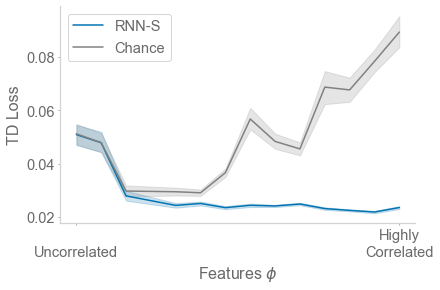

In [13]:
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.9))
sns.lineplot(
    x='Sigma', y='Final Loss',
    ax = ax, data=df[(df['Gamma']==_gamma) & (df['Model']=='RNN-S')],
    label='RNN-S'
    )
sns.lineplot(
    x='Sigma', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==_gamma) & (df['Model']=='RNN-S')],
    color='Gray', label='Chance'
    )
plt.xticks([0.0, sigmas.max()], ['\nUncorrelated', 'Highly\nCorrelated'])
plt.xlabel('Features $\phi$')
plt.ylabel('TD Loss')
plt.tight_layout()
plt.savefig('4a_corrlineplot.png', dpi=300)

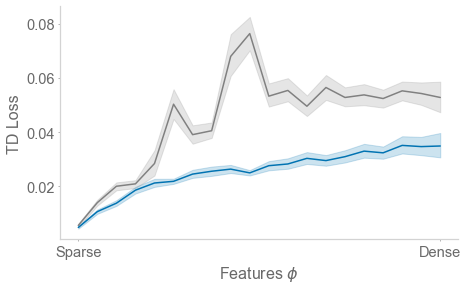

In [14]:
fig, ax = plt.subplots(figsize=(6.8, 4.8*0.9))
sns.lineplot(
    x='Sparsity', y='Final Loss',
    ax = ax, data=df[(df['Gamma']==_gamma) & (df['Model']=='RNN-S')],
    legend=None
    )
sns.lineplot(
    x='Sparsity', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==_gamma) & (df['Model']=='RNN-S')],
    color='Gray', label='Chance', legend=None
    )
xtick1 = df['Sparsity'].min()
xtick2 = df['Sparsity'].max()
plt.xticks([xtick1, xtick2], ['Sparse', 'Dense'])
plt.xlabel('Features $\phi$')
plt.ylabel('TD Loss')
plt.tight_layout()
plt.savefig('4a_sparselineplot.png', dpi=300)

# Make gradient plots

In [44]:
_gamma = 0.75

In [45]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [46]:
def get_edge_nans(im):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    mask = np.zeros(im.shape).astype(bool)
    nrows, ncols = im.shape
    for i in range(nrows):
        j = 0
        while np.isnan(im[i,j]) and (j < ncols):
            mask[i,j] = True
            j += 1
    return mask

In [47]:
plt.rcParams.update({'hatch.color': 'darkgray'})

In [48]:
def make_gradients(
    xs, ys, zs, models, cmap="Reds",
    plottype='RNN-SF', chance_relative=False, chance_zs=None,
    title=None, xlabel=None, ylabel=None,
    figname=None, figsize=[6.4, 4.8],
    interpolate=False, smooth=False, contours=None,
    leave_edge_nans=True, xlim=None, vmin=1., vmax=9.
    ):
    
    # Collect data into a meshgrid
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            ij_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models==plottype
                )
            _val = np.nanmean(zs[ij_idx])
            if chance_relative:
                _chance_val = np.nanmean(chance_zs[ij_idx])
                val = _chance_val/_val
            else:
                val = _val
            z[i,j] = val
    
    # Plot raw grid values
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')
    fig, ax = plt.subplots()
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]

    # Mark NaNs
    nan_mask = np.isnan(z)
    edge_nan_mask = get_edge_nans(z)

    # Interpolate to fill in NaN cells
    if interpolate:
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals

    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(x_stddev=1, y_stddev=1)
        z = convolve(z, kernel, preserve_nan=True)
    
    # Generate contour plots
    z = np.clip(z, vmin, vmax)
    if vmin is not None and vmax is not None:
        levels = MaxNLocator(nbins=20).tick_values(vmin, vmax)
    else:
        levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(x, y, z, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
    if leave_edge_nans: # White out parts that were extrapolated
        nans = np.argwhere(edge_nan_mask)
        nan1 = nans[0]; nan2 = nans[-1]
        nan1x = x[nan1[0],nan1[1]]
        nan1y = y[nan1[0],nan1[1]]
        nan2x = x[nan2[0],nan2[1]]
        nan2y = y[nan2[0],nan2[1]]
        max_y = y.max()
        plt.fill(
            [nan1x, nan2x, nan1x],
            [nan1y, nan2y, max_y],
            color='white'
            )
    if xlim is not None: # Adjust x limits
        plt.xlim(xlim)
    if contours is not None: # Draw contours
        cntrs = plt.contourf(
            x, y, z, contours,
            hatches='//', alpha=0.01, colors='white'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax, ticks=levels[1::2])
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:28: RuntimeWarning: Mean of empty slice
  _val = np.nanmean(zs[ij_idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:38: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


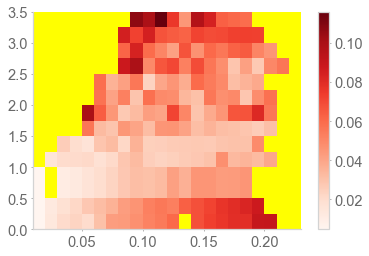

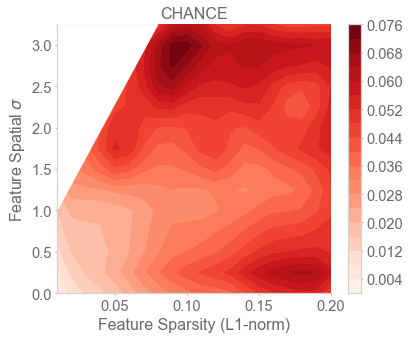

In [49]:
# RNN
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _chance_losses, _models,
    title='CHANCE',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-S',
    chance_zs = _chance_losses,
    xlim=[_sparsities.min(), 0.2],
    contours=[100, 200],
    chance_relative=False, vmax=0.076, vmin=0
    #contours=[0.0, 1.0],
    #chance_relative=True, vmax=7.6, vmin=1.
    )

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:28: RuntimeWarning: Mean of empty slice
  _val = np.nanmean(zs[ij_idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:38: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


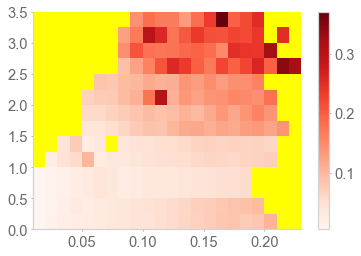

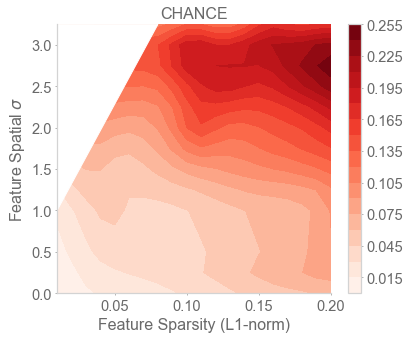

In [50]:
# Linear
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _chance_losses, _models,
    title='CHANCE',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_linear_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='FF-TD',
    chance_zs = _chance_losses,
    xlim=[_sparsities.min(), 0.2],
    contours=[100, 200],
    chance_relative=False, vmax=None, vmin=0,
    #chance_relative=True,
    #contours=[0.0, 1.0], vmax=7.6
    )

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:28: RuntimeWarning: Mean of empty slice
  _val = np.nanmean(zs[ij_idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:38: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


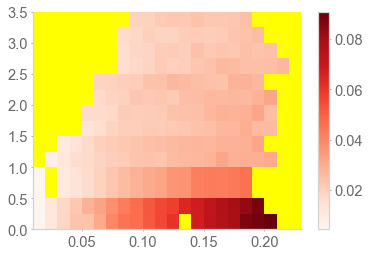

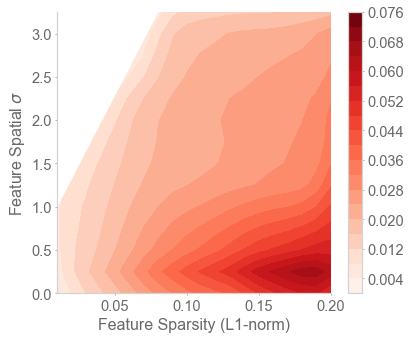

In [51]:
# RNN
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-S',
    chance_zs = _chance_losses,
    xlim=[_sparsities.min(), 0.2],
    contours=[100, 200],
    chance_relative=False, vmax=0.076, vmin=0
    #contours=[0.0, 1.0],
    #chance_relative=True, vmax=7.6, vmin=1.
    )

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:28: RuntimeWarning: Mean of empty slice
  _val = np.nanmean(zs[ij_idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:38: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_23910/1658614743.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


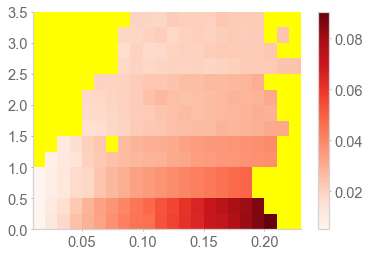

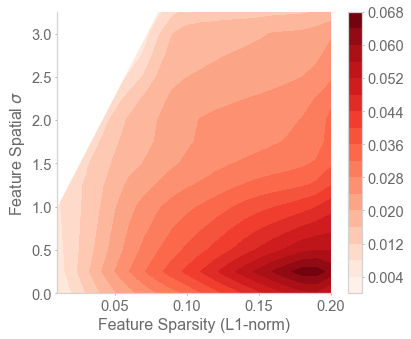

In [52]:
# Linear
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_linear_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='FF-TD',
    chance_zs = _chance_losses,
    xlim=[_sparsities.min(), 0.2],
    contours=[100, 200],
    chance_relative=False, vmax=None, vmin=0,
    #chance_relative=True,
    #contours=[0.0, 1.0], vmax=7.6
    )

## Loss as a function of gamma

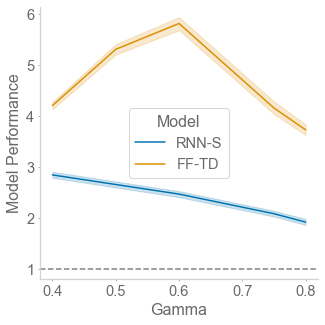

In [27]:
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8))
sns.lineplot(
    x='Gamma', y='Fold Improvement from Chance',
    hue='Model', ax=ax,
    data=df[~((df['Model']=='RNN-S') & (df['Gamma']==0.5))],
    hue_order=['RNN-S', 'FF-TD'],
    #legend=None
    )
ax.set_ylim(0.8)
ax.axhline(1.0, color='gray', linestyle='--')
ax.set_ylabel('Model Performance')
plt.tight_layout()
plt.savefig('4a_gamma_perf.png', dpi=300)

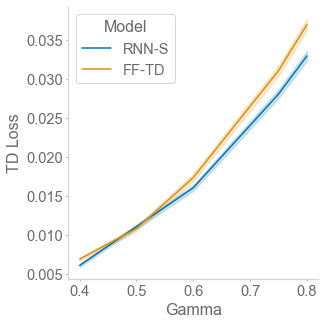

In [33]:
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8))
sns.lineplot(
    x='Gamma', y='Final Loss',
    hue='Model', ax=ax,
    data=df[~((df['Model']=='RNN-S') & (df['Gamma']==0.5))],
    hue_order=['RNN-S', 'FF-TD']
    #legend=None
    )
ax.set_ylabel('TD Loss')
plt.tight_layout()
plt.savefig('4a_gamma_tdloss.png', dpi=300)